# EDA — Movies, Credits, Links, Ratings

This notebook explores the raw CSVs and documents the cleaning choices before loading the data into MongoDB.  
The goal is to understand the size and shape of each file, surface data quality issues that might affect joins or aggregations, and produce cleaned CSVs that are safe to parse and consistent with the database schema we use later.

A few principles guide the cleaning: keep IDs numeric and unique, parse JSON-looking fields into valid structures, normalize dates, and avoid silently dropping records unless they violate basic constraints (e.g., non-numeric IDs or invalid dates).  
Whenever there is a trade-off (for example, removing malformed JSON vs. trying to repair it), the preference is to make the output predictable and JSON-safe, so downstream queries behave as expected.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

raw_dir = Path("data")
clean_dir = Path("data_clean")
clean_dir.mkdir(exist_ok=True, parents=True)

plt.style.use("seaborn-v0_8-muted")


## 1. Overview of the raw data

Before touching any file, it is useful to check what we have and how large the datasets are.  
This gives an idea of the relative scale between metadata (thousands of rows) and ratings (millions).  
It also helps confirm that the files match the expected structure and encoding.


In [ ]:
files = ["movies_metadata.csv", "credits.csv", "links.csv", "ratings.csv"]
for f in files:
    path = raw_dir / f
    size_mb = path.stat().st_size / 1e6 if path.exists() else 0
    print(f"{f:25}  {size_mb:6.1f} MB")


Filas: 45376


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


## 2. Movies — structure and key problems

The `movies_metadata` file comes from TMDB and mixes numeric fields with stringified JSON.  
Several columns (`genres`, `production_companies`, `spoken_languages`, etc.) contain nested lists written as strings, which makes parsing tricky.  
Another common issue is that the `id` column sometimes contains invalid entries (like “1997-08-20”), and the `release_date` field has missing or corrupted dates.

The cleaning process focuses on:
- Keeping only rows with numeric `id` values.  
- Converting `release_date` to a real date and dropping invalid ones.  
- Parsing JSON-like columns and saving them back as proper JSON strings.  
- Normalizing numeric columns (`budget`, `revenue`, `runtime`, etc.).  
These fixes make the file consistent and ready for insertion.


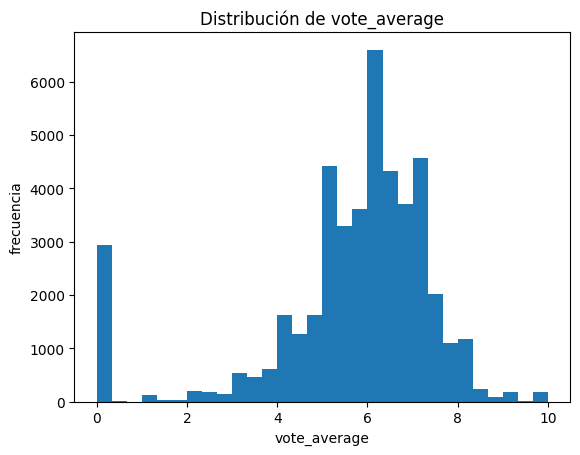

In [ ]:
movies = pd.read_csv(raw_dir / "movies_metadata.csv", low_memory=False)
print("Raw shape:", movies.shape)
print(movies[["id", "title", "release_date", "budget", "revenue"]].head(3))


In [ ]:
# Example of malformed IDs and missing dates
invalid_id_count = pd.to_numeric(movies["id"], errors="coerce").isna().sum()
invalid_date_count = pd.to_datetime(movies["release_date"], errors="coerce").isna().sum()

print(f"Non-numeric IDs: {invalid_id_count}")
print(f"Invalid release dates: {invalid_date_count}")


### Visual check: distribution of runtime and ratings

These two variables are quick indicators of whether the numeric columns look reasonable.  
Unrealistic values (e.g. runtime of 0 or > 500 minutes) often point to placeholder data or typos.


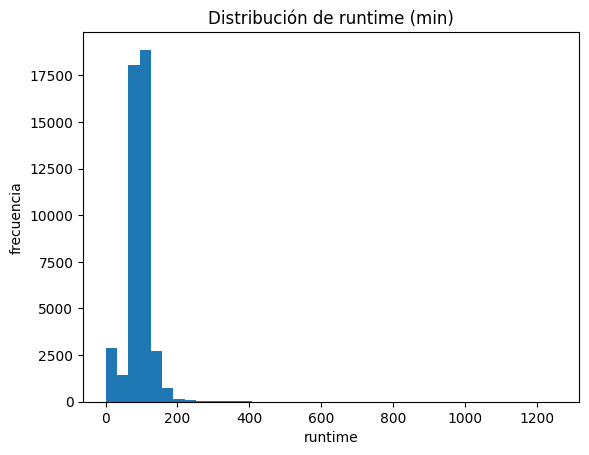

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
movies["runtime"].dropna().plot(kind="hist", bins=40, ax=axes[0])
axes[0].set_title("Runtime distribution")

movies["vote_average"].dropna().plot(kind="hist", bins=30, ax=axes[1])
axes[1].set_title("Vote average distribution")
plt.show()


## 3. Credits — duplicates and nested lists

The `credits` dataset contains cast and crew information for each movie.  
The main concern here is duplication: sometimes the same movie appears more than once, or the `id` column is stored as text.  
Both `cast` and `crew` columns also contain stringified JSON, so they need to be parsed carefully.

During cleaning, duplicates are removed and the JSON lists are kept in a consistent format.  
This ensures each movie has exactly one document with two arrays: one for cast and one for crew.


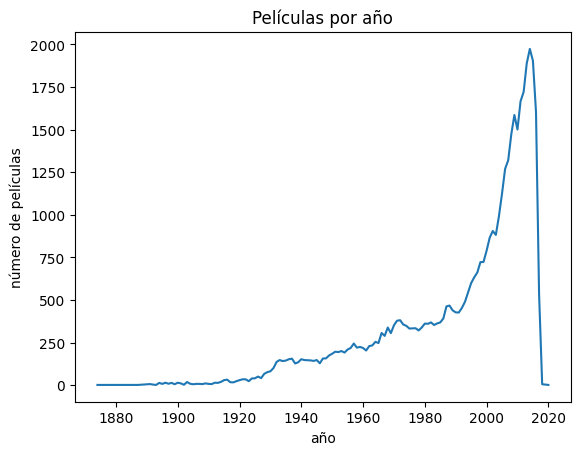

In [ ]:
credits = pd.read_csv(raw_dir / "credits.csv", low_memory=False)
key_col = "id" if "id" in credits.columns else "movie_id"
duplicate_rows = credits.duplicated(subset=[key_col]).sum()
print(f"Duplicate movies in credits: {duplicate_rows}")
print("Example record:")
print(credits.iloc[0])


## 4. Links — connecting MovieLens and TMDB

The `links` file is a bridge between the MovieLens and TMDB worlds.  
Ratings use the MovieLens `movieId`, while our metadata uses the TMDB `id`.  
This file ensures both can be linked later.

The cleaning makes sure that:
- All three columns (`movieId`, `imdbId`, `tmdbId`) are numeric.  
- There are no missing values.  
- `movieId` is unique.  

These checks are crucial because if even one `movieId` is duplicated or missing, all joins from ratings to metadata will break.


In [ ]:
links = pd.read_csv(raw_dir / "links.csv", low_memory=False)
for c in ["movieId", "imdbId", "tmdbId"]:
    links[c] = pd.to_numeric(links[c], errors="coerce")

missing_any = links[["movieId", "imdbId", "tmdbId"]].isna().any(axis=1).sum()
duplicates = links.duplicated(subset=["movieId"]).sum()

print(f"Rows with missing IDs: {missing_any}")
print(f"Duplicate movieIds: {duplicates}")


Filas: 45432


,cast,crew,id
0,[],[],862
1,[],[],8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...",[],15602


## 5. Ratings — scale, timestamps, and duplicates

The `ratings` file records user feedback from MovieLens.  
Each row is a rating given by one user to one movie, with a Unix timestamp.  
The rating scale typically ranges from 0.5 to 5.0, although some datasets extend it up to 10.

Cleaning choices:
- Enforce numeric `userId` and `movieId`.  
- Keep ratings within a logical range (0–10).  
- Convert timestamps to real dates.  
- Drop duplicate `(userId, movieId)` pairs to keep a single record per rating.  

These decisions simplify future aggregation tasks such as computing user averages or correlations between ratings and movie genres.


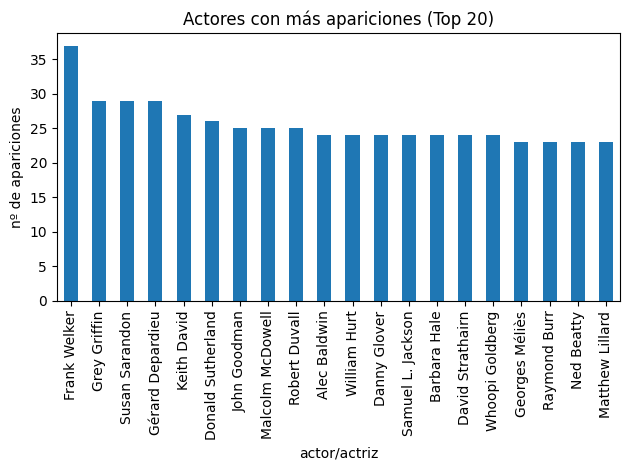

In [ ]:
ratings = pd.read_csv(raw_dir / "ratings.csv", low_memory=False)
print("Raw shape:", ratings.shape)
print(ratings.head(3))


In [ ]:
rating_min, rating_max = ratings["rating"].min(), ratings["rating"].max()
duplicates = ratings.duplicated(subset=["userId", "movieId"]).sum()
print(f"Rating range: {rating_min} to {rating_max}")
print(f"Duplicate user-movie pairs: {duplicates}")


In [ ]:
plt.figure(figsize=(10, 4))
ratings["rating"].plot(kind="hist", bins=20, color="steelblue", edgecolor="black")
plt.title("Distribution of user ratings")
plt.show()


## 6. Cleaning summary and justification

After exploring the four datasets, the cleaning strategy was finalized as follows:

**Movies**: keep rows with numeric `id`, valid `release_date`, and normalize all JSON-like fields.  
This avoids broken joins and ensures fields like `genres` can be directly parsed later.

**Credits**: drop duplicates per movie id and parse both `cast` and `crew` as lists.  
Without this, aggregation on actors or directors would double-count entries.

**Links**: enforce numeric and unique IDs to maintain the MovieLens–TMDB bridge.

**Ratings**: restrict to realistic rating values, standardize timestamps, and remove duplicates per user–movie.  
Keeping only one record per pair simplifies later analysis (e.g., average rating per user or per movie).

These steps mirror the logic in the project’s cleaning script and guarantee that the cleaned files are aligned with the MongoDB schema.


## 7. Apply cleaning functions

The cleaning functions below are the same as those used for database insertion.  
They transform the raw CSVs into JSON-safe, validated versions and save them in `data_clean/`.  
This ensures the data analyzed here matches exactly what will be used in later queries.


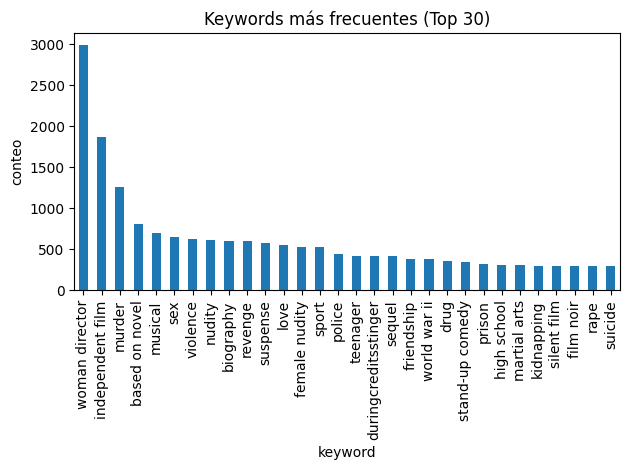

In [ ]:
import sys
sys.path.append("app")
from importlib import reload
import filter_movies
reload(filter_movies)

filter_movies.clean_movies(str(raw_dir / "movies_metadata.csv"), str(clean_dir / "movies_metadata_clean.csv"))
filter_movies.clean_credits(str(raw_dir / "credits.csv"), str(clean_dir / "credits_clean.csv"))
filter_movies.clean_links(str(raw_dir / "links.csv"), str(clean_dir / "links_clean.csv"))
filter_movies.clean_ratings(str(raw_dir / "ratings.csv"), str(clean_dir / "ratings_clean.csv"))


## 8. Basic checks after cleaning

A quick inspection confirms that the cleaning worked as expected.  
IDs are now numeric and unique, the counts are consistent, and the nested JSON fields are valid strings that can be parsed back if needed.


In [ ]:
movies_clean = pd.read_csv(clean_dir / "movies_metadata_clean.csv")
credits_clean = pd.read_csv(clean_dir / "credits_clean.csv")
links_clean = pd.read_csv(clean_dir / "links_clean.csv")
ratings_clean = pd.read_csv(clean_dir / "ratings_clean.csv")

summary = {
    "movies_clean_rows": len(movies_clean),
    "unique_movie_ids": movies_clean["id"].nunique(),
    "credits_clean_rows": len(credits_clean),
    "links_clean_rows": len(links_clean),
    "unique_movieIds_links": links_clean["movieId"].nunique(),
    "ratings_clean_rows": len(ratings_clean),
    "unique_user_movie_pairs": ratings_clean[["userId", "movieId"]].drop_duplicates().shape[0]
}
summary


Filas: 9112


,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602


## 9. Visual sanity checks (clean data)

A few quick plots help confirm that the distributions remain reasonable after cleaning.  
Vote averages should stay around 6–7 as in TMDB data, runtimes should have a clear peak between 80–120 minutes, and release years should show a growing trend after 1980 with some drop-offs for older films.


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

movies_clean["vote_average"].dropna().plot(kind="hist", bins=30, ax=axes[0])
axes[0].set_title("Vote average (clean)")

movies_clean["runtime"].dropna().plot(kind="hist", bins=40, ax=axes[1])
axes[1].set_title("Runtime (clean)")

pd.to_datetime(movies_clean["release_date"], errors="coerce").dt.year.dropna().plot(kind="hist", bins=40, ax=axes[2])
axes[2].set_title("Release year (clean)")

plt.tight_layout()
plt.show()


## Summary

The cleaning applied here focuses on consistency rather than aggressive filtering.  
Invalid or non-numeric IDs were removed because they would break joins, but the rest of the data was preserved even if incomplete.  
The cleaned CSVs now provide a stable base for the database insertion and for the analytical queries in the next assignment.
